In [1]:
%matplotlib inline

import os

import keras as keras
import numpy as np
import matplotlib.pyplot as plt

from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.datasets import cifar10
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

random_state = 42

C:\Users\yanor\Anaconda3\envs\matsuo\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Section2 実装①
### 2.1 Fashion MNISTをCNNでクラス文分類
Fashion MNISTのデータをCNNを利用してクラス分類を行う。

#### 2.1.1 データセットの読み込み

In [2]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

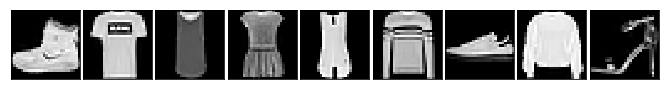

In [3]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i], cmap='gray')

このとき読み込んだ画像は(バッチサイズ、縦の画素数、横の画素数)の次元で表されている。

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
x_train = x_train.reshape((x_train.shape[0], 28, 28, 1)) / 255
x_test = x_test.reshape((x_test.shape[0], 28, 28, 1)) / 255
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

Lesson1の多層パーセプトロンでは入力を(バッチサイズ、画素数)の2次元テンソルとして扱ったが、CNNでは2次元の画像として処理していくために4次元テンソル(バッチサイズ、縦の画素数、横の画素数、チャネル数)として扱う。チャンネル数は白黒画像の場合は１、カラーの場合はRGBで3となる。

Fashion MNISTに画像は白黒画像なのでチャンネル数は1に設定している。

In [6]:
x_train.shape

(60000, 28, 28, 1)

#### 2.1.2 実装

In [7]:
model = Sequential()

# 入力画像 28x28x1 (縦の画素数)x(横の画素数)x(チャンネル数)
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(28, 28, 1)))  # 28x28x1 -> 24x24x16
model.add(MaxPooling2D(pool_size=(2, 2)))  # 24x24x16 -> 12x12x16
model.add(Conv2D(64, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  # 12x12x16 -> 8x8x64
model.add(MaxPooling2D(pool_size=(2, 2)))  # 8x8x64 -> 4x4x64

model.add(Flatten())  # 4x4x64-> 1024
model.add(Dense(10, activation='softmax'))  # 1024 -> 10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

作成したモデルを確認してみる。

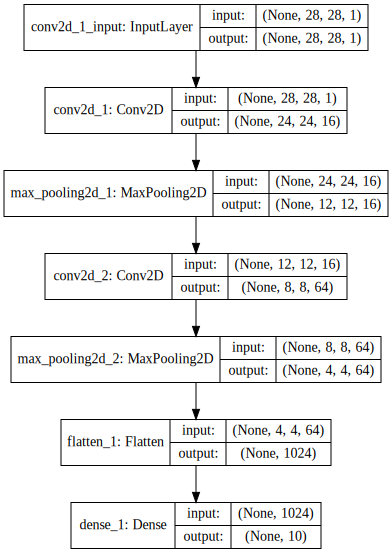

In [8]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
early_stopping = EarlyStopping(patience=1, verbose=1)
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, verbose=1,
          validation_data=(x_test, y_test), callbacks=[early_stopping])

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 84s 1ms/step - loss: 0.5501 - acc: 0.8078 - val_loss: 0.4382 - val_acc: 0.8377
Epoch 2/100
60000/60000 [==============================] - 83s 1ms/step - loss: 0.3659 - acc: 0.8711 - val_loss: 0.3768 - val_acc: 0.8661
Epoch 3/100
60000/60000 [==============================] - 143s 2ms/step - loss: 0.3213 - acc: 0.8855 - val_loss: 0.3394 - val_acc: 0.8754
Epoch 4/100
60000/60000 [==============================] - 133s 2ms/step - loss: 0.2891 - acc: 0.8978 - val_loss: 0.3186 - val_acc: 0.8855
Epoch 5/100
60000/60000 [==============================] - 126s 2ms/step - loss: 0.2683 - acc: 0.9046 - val_loss: 0.2979 - val_acc: 0.8902
Epoch 6/100
60000/60000 [==============================] - 125s 2ms/step - loss: 0.2527 - acc: 0.9098 - val_loss: 0.2951 - val_acc: 0.8970
Epoch 7/100
60000/60000 [==============================] - 154s 3ms/step - loss: 0.2359 - acc: 0.9155 - val_loss: 0.29

### 2.2 CIFAR10のデータをCNNでクラス分類
#### 2.2.1 データセットの読みこみ
6万枚のカラー画像に10のカテゴリのどれかが付与されたCIFAR-10というデータセットを使用する。

まず、データを読みこむ。

In [10]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
y_train = np.eye(10)[y_train.astype('int32').flatten()]

x_test = x_test.astype('float32') / 255
y_test = np.eye(10)[y_test.astype('int32').flatten()]

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10000)

170500096/170498071 [==============================] - 42s 0us/step


画像はRGBデータなのでFashion MNISTとは異なり、チャンネル数は3。

In [11]:
x_train.shape

(40000, 32, 32, 3)

次に、CIFAR-10の画像の例を表示する。この画像1つ1つに10のカテゴリのうちひとつが付与されている。

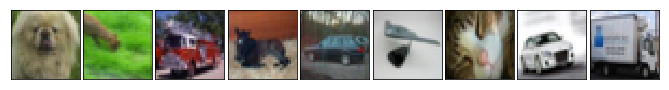

In [12]:
fig = plt.figure(figsize=(9, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05,
                    wspace=0.05)

for i in range(9):
    ax = fig.add_subplot(1, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i])

以下のネットワークを実装してみる。

![CIFAR-10ネットワーク](https://github.com/matsuolab-edu/dl4us/raw/b34f8964fe3cdbbf0dd527dc381926721538ac8c/lesson2/figures/lenet.png)

#### 2.2.2 実装

In [13]:
model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(32, 32, 3)))  # 32x32x3 -> 28x28x6
model.add(MaxPooling2D(pool_size=(2, 2)))  # 28x28x6 -> 14x14x6
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  # 14x14x6 -> 10x10x16
model.add(MaxPooling2D(pool_size=(2, 2)))  # 10x10x16 -> 5x5x16

model.add(Flatten())  # 5x5x16 -> 400
model.add(Dense(120, activation='relu',
                kernel_initializer='he_normal'))  # 400 ->120
model.add(Dense(84, activation='relu', kernel_initializer='he_normal'))  # 120 ->84
model.add(Dense(10, activation='softmax'))  # 84 ->10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

作成したモデルを確認してみる。

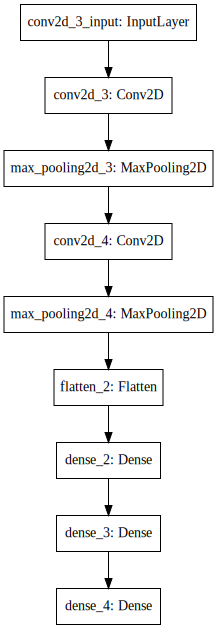

In [14]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [15]:
early_stopping = EarlyStopping(patience=1, verbose=1)
model.fit(x=x_train, y=y_train, batch_size=128, epochs=100, verbose=1,
          validation_data=(x_valid, y_valid), callbacks=[early_stopping])

Train on 40000 samples, validate on 10000 samples
Epoch 1/100
40000/40000 [==============================] - 156s 4ms/step - loss: 1.7477 - acc: 0.3615 - val_loss: 1.5268 - val_acc: 0.4540
Epoch 2/100
40000/40000 [==============================] - 142s 4ms/step - loss: 1.4563 - acc: 0.4762 - val_loss: 1.4204 - val_acc: 0.4932
Epoch 3/100
40000/40000 [==============================] - 128s 3ms/step - loss: 1.3495 - acc: 0.5159 - val_loss: 1.3525 - val_acc: 0.5152
Epoch 4/100
40000/40000 [==============================] - 118s 3ms/step - loss: 1.2753 - acc: 0.5457 - val_loss: 1.3329 - val_acc: 0.5255
Epoch 5/100
40000/40000 [==============================] - 142s 4ms/step - loss: 1.2189 - acc: 0.5672 - val_loss: 1.3121 - val_acc: 0.5355
Epoch 6/100
40000/40000 [==============================] - 133s 3ms/step - loss: 1.1676 - acc: 0.5883 - val_loss: 1.2704 - val_acc: 0.5515
Epoch 7/100
40000/40000 [==============================] - 166s 4ms/step - loss: 1.1308 - acc: 0.5988 - val_loss: 1.